# TN DCS CANS Assessment Data Analysis

In [ ]:
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
import re

import geopandas as gpd 



pd.set_option('display.max_columns', None) 

<h3 style="color:navy">Import Data</h3>

In [2]:
df_youth = pd.read_csv('../data/bdaic created tables/df_youth.csv', dtype={'PERSON ID': str, 'REMOVAL ZIP CODE': str, 'PLACEMENT ZIP CODE': str}, 
parse_dates=['LOCATION BEGIN DATE', 'LOCATION END DATE'])
df_data = pd.read_csv('../data/bdaic created tables/df_assessment_questions.csv', dtype={'PERSON ID': str}) 

In [3]:
### Summary of Youth Data
print('df_youth shape:\n', df_youth.shape)
print('\ndf_youth columns:\n', df_youth.columns)
print('\ndf_youth dtypes:\n', df_youth.dtypes)

df_youth shape:
 (5684, 11)

df_youth columns:
 Index(['PERSON ID', 'CURRENT AGE', 'COMMITMENT COUNTY', 'RESPONSIBLE COUNTY',
       'GENDER', 'REMOVAL ZIP CODE', 'PLACEMENT ZIP CODE',
       'LOCATION BEGIN DATE', 'LOCATION END DATE', 'CANS', 'LIFESKILL'],
      dtype='object')

df_youth dtypes:
 PERSON ID                      object
CURRENT AGE                     int64
COMMITMENT COUNTY              object
RESPONSIBLE COUNTY             object
GENDER                         object
REMOVAL ZIP CODE               object
PLACEMENT ZIP CODE             object
LOCATION BEGIN DATE    datetime64[ns]
LOCATION END DATE      datetime64[ns]
CANS                          float64
LIFESKILL                     float64
dtype: object


In [4]:
### Summary of Assessment Data
print('df_data shape:\n', df_data.shape)
print('\ndf_data columns:\n', df_data.columns)
print('\ndf_data dtypes:\n', df_data.dtypes)

df_data shape:
 (555168, 5)

df_data columns:
 Index(['PERSON ID', 'ASSESSMENT TYPE', 'ASSESSMENT INDICATOR', 'SCORE-RESULT',
       'GENERAL RESULT DESCRIPTION'],
      dtype='object')

df_data dtypes:
 PERSON ID                     object
ASSESSMENT TYPE               object
ASSESSMENT INDICATOR          object
SCORE-RESULT                  object
GENERAL RESULT DESCRIPTION    object
dtype: object


In [5]:
# Create summary statistics
total_youth = len(df_youth['PERSON ID'].unique())
cans_youth = len(df_youth[df_youth['CANS'] == 1.0]['PERSON ID'].unique())
lifeskill_youth = len(df_youth[df_youth['LIFESKILL'] == 1.0]['PERSON ID'].unique())
gender_counts = df_youth['GENDER'].value_counts()
age_stats = df_youth['CURRENT AGE'].describe()

# Print summary with formatting
print('Summary of Youth Dataset\n' + '='*25)
print(f'\nTotal Unique Youth: {total_youth:,}')
print(f'Youth with CANS Assessment: {cans_youth:,}')
print(f'Youth with LIFESKILL Assessment: {lifeskill_youth:,}')

print('\nGender Breakdown:')
print('-----------------')
for gender, count in gender_counts.items():
    percentage = (count/len(df_youth))*100
    print(f'{gender}: {count:,} ({percentage:.1f}%)')

print('\nAge Distribution:')
print('----------------')
print(f'Average Age: {age_stats["mean"]:.1f}')
print(f'Minimum Age: {age_stats["min"]:.0f}')
print(f'Maximum Age: {age_stats["max"]:.0f}')
print('\nAge Breakdown:')
age_counts = df_youth['CURRENT AGE'].value_counts().sort_index()
for age, count in age_counts.items():
    percentage = (count/len(df_youth))*100
    print(f'Age {age:.0f}: {count:,} ({percentage:.1f}%)')


Summary of Youth Dataset

Total Unique Youth: 5,684
Youth with CANS Assessment: 5,667
Youth with LIFESKILL Assessment: 374

Gender Breakdown:
-----------------
MALE: 3,342 (58.8%)
FEMALE: 2,342 (41.2%)

Age Distribution:
----------------
Average Age: 18.2
Minimum Age: 16
Maximum Age: 21

Age Breakdown:
Age 16: 108 (1.9%)
Age 17: 1,705 (30.0%)
Age 18: 1,630 (28.7%)
Age 19: 1,295 (22.8%)
Age 20: 897 (15.8%)
Age 21: 49 (0.9%)


In [6]:
### Make some formating adustments to df_data 
# Rename assessment type and indicator columns to proper case
df_data = df_data.rename(columns={
    'ASSESSMENT TYPE': 'Assessment Type',
    'ASSESSMENT INDICATOR': 'Assessment Indicator'
})

df_data.head() 

,PERSON ID,Assessment Type,Assessment Indicator,SCORE-RESULT,GENERAL RESULT DESCRIPTION
0,353258,CANS,Sexual Abuse,0,No current need; no need for action or interv...
1,353258,CANS,Physical Abuse,0,No current need; no need for action or interv...
2,353258,CANS,Emotional Abuse,0,No current need; no need for action or interv...
3,353258,CANS,Neglect,2,Action or intervention is required to ensure ...
4,353258,CANS,Medical Trauma,0,No current need; no need for action or interv...


### Categorize CANS Questions

In [7]:
# Get CANS assessment indicators and counts
cans_indicators = df_data[df_data['Assessment Type'] == 'CANS'].groupby('Assessment Indicator')['PERSON ID'].nunique().reset_index()
cans_indicators.columns = ['Assessment Indicator', 'Number of Youth']

# Calculate percentage of youth who completed CANS
cans_indicators['Percent of Total Youth'] = (cans_indicators['Number of Youth'] / cans_youth * 100).round(1)

# Sort by number of youth descending
cans_indicators = cans_indicators.sort_values('Number of Youth', ascending=False)

print("CANS Assessment Indicators Summary:")
print("==================================")
print(cans_indicators.to_string(index=False))


CANS Assessment Indicators Summary:
                         Assessment Indicator  Number of Youth  Percent of Total Youth
                             Medical/Physical             5667                   100.0
                                     Runaway*             5667                   100.0
                             Family Strengths             5667                   100.0
                                 Fire Setting             5667                   100.0
                  Sexually Reactive Behavior*             5667                   100.0
                           Sexual Development             5667                   100.0
                    Impulsivity/Hyperactivity             5667                   100.0
                            Sexual Aggression             5667                   100.0
                      Intentional Misbehavior             5667                   100.0
           Interpersonal/Social Connectedness             5667                   100.0
       

In [8]:
# Create dictionary mapping indicators to categories
indicator_categories = {
    # Mental Health indicators
    'Decision-Making (Judgement)': 'Mental Health',             # Behavioral & Impulse Control
    'Impulsivity/Hyperactivity': 'Mental Health',               # Behavioral & Impulse Control
    'School Behavior': 'Mental Health',                         # Behavioral & Impulse Control
    'Substance Use': 'Mental Health',                           # Behavioral & Impulse Control
    'Spiritual/Religious': 'Mental Health',                     # Cultural, Spiritual, and Engagement Factors
    'Traditions And Rituals': 'Mental Health',                  # Cultural, Spiritual, and Engagement Factors
    'Youth Involvement With Care': 'Mental Health',             # Cultural, Spiritual, and Engagement Factors
    'Anger Control': 'Mental Health',                           # Mood & Emotional Regulation 
    'Anxiety': 'Mental Health',                                 # Mood & Emotional Regulation 
    'Depression': 'Mental Health',                              # Mood & Emotional Regulation 
    'Emotional And/Or Physical Dysregulation': 'Mental Health', # Mood & Emotional Regulation 
    'Numbing': 'Mental Health',                                 # Mood & Emotional Regulation 
    'Medical/Physical': 'Mental Health',                        # Physical & Medical 
    'Psychosis (Thought Disorder)': 'Mental Health',            # Psychotic & Thought Disturbances
    'Danger To Others': 'Mental Health',                        # Risk & Safety
    'Intentional Misbehavior': 'Mental Health',                 # Risk & Safety  
    'Non-Suicidal Self-Injurious Behavior': 'Mental Health',    # Risk & Safety
    'Other Self-Harm (Recklessness)': 'Mental Health',          # Risk & Safety
    'Suicide Risk': 'Mental Health',                            # Risk & Safety 
    'Sexual Aggression': 'Mental Health',                       # Sexual & Developmental Concerns
    'Sexual Development': 'Mental Health',                      # Sexual & Developmental Concerns
    'Adjustment To Trauma': 'Mental Health',                    # Trauma & Stress-Related
    'Cultural Stress': 'Mental Health',                         # Trauma & Stress-Related
    'Emotional Abuse': 'Mental Health',                         # Trauma & Stress-Related
    'Environmental Influences': 'Mental Health',                # Trauma & Stress-Related
    'Medical Trauma': 'Mental Health',                          # Trauma & Stress-Related
    'Sexual Abuse': 'Mental Health',                            # Trauma & Stress-Related
    
    
    # Supportive Adult Relationships indicators
    'Attachment Difficulties': 'Supportive Adult Relationships',
    'Community Life': 'Supportive Adult Relationships',
    'Family Functioning': 'Supportive Adult Relationships',
    'Family Strengths': 'Supportive Adult Relationships',
    'Interpersonal/Social Connectedness': 'Supportive Adult Relationships',
    'Natural Supports': 'Supportive Adult Relationships',
    'Neglect': 'Supportive Adult Relationships',
    'Oppositional(Non-compliance with Authority)': 'Supportive Adult Relationships',
    'Relationship Permanence': 'Supportive Adult Relationships',
    'Social Functioning': 'Supportive Adult Relationships',
    
    # Housing Instability indicators
    'Independent Living Skills': 'Housing',
    'Living Situation': 'Housing Instability', 
    'Physical Abuse': 'Housing Instability',
    'Runaway*': 'Housing Instability',
    'Youth Residential Stability': 'Housing Instability'
}

# Add category column
cans_indicators['Pillar'] = cans_indicators['Assessment Indicator'].map(indicator_categories)

# Display categorized indicators
print("\nCategorized CANS Assessment Indicators:")
print("======================================")
for category in ['Mental Health', 'Supportive Adult Relationships', 'Housing Instability']:
    print(f"\n{category}:")
    print(cans_indicators[cans_indicators['Pillar'] == category][['Assessment Indicator', 'Number of Youth']].to_string(index=False))



Categorized CANS Assessment Indicators:

Mental Health:
                   Assessment Indicator  Number of Youth
                       Medical/Physical             5667
                     Sexual Development             5667
              Impulsivity/Hyperactivity             5667
                      Sexual Aggression             5667
                Intentional Misbehavior             5667
                           Sexual Abuse             5667
                        School Behavior             5667
                         Medical Trauma             5667
                          Anger Control             5667
   Non-Suicidal Self-Injurious Behavior             5667
         Other Self-Harm (Recklessness)             5667
                        Emotional Abuse             5667
                                Anxiety             5667
                 Traditions And Rituals             5667
                           Suicide Risk             5667
                          Subst

In [9]:
### Filter CANS indicators to pillar-related indicators only 
pillar_indicators = cans_indicators[cans_indicators['Pillar'].notna()]

print(pillar_indicators.shape)
pillar_indicators.head()

(42, 4)


,Assessment Indicator,Number of Youth,Percent of Total Youth,Pillar
50,Medical/Physical,5667,100.0,Mental Health
69,Runaway*,5667,100.0,Housing Instability
33,Family Strengths,5667,100.0,Supportive Adult Relationships
78,Sexual Development,5667,100.0,Mental Health
37,Impulsivity/Hyperactivity,5667,100.0,Mental Health


<h3 style="color:navy">Filter CANS indicators to pillar-related indicators only</h3>

In [10]:
df_pillar = df_data.merge(pillar_indicators[['Assessment Indicator', 'Pillar']], how='inner', on='Assessment Indicator') 

print(df_pillar.shape)
df_pillar.head()


(232744, 6)


,PERSON ID,Assessment Type,Assessment Indicator,SCORE-RESULT,GENERAL RESULT DESCRIPTION,Pillar
0,353258,CANS,Sexual Abuse,0,No current need; no need for action or interv...,Mental Health
1,706512,CANS,Sexual Abuse,1,"Identified need requires monitoring, watchful...",Mental Health
2,1348374,CANS,Sexual Abuse,2,Action or intervention is required to ensure ...,Mental Health
3,2470086,CANS,Sexual Abuse,0,No current need; no need for action or interv...,Mental Health
4,3965628,CANS,Sexual Abuse,0,No current need; no need for action or interv...,Mental Health


In [11]:
df_pillar_pivot = df_pillar.pivot_table(index='PERSON ID', columns='Assessment Indicator', values='SCORE-RESULT', aggfunc='first')

print(df_pillar_pivot.shape)
df_pillar_pivot.head()




(5667, 42)


Assessment Indicator,Adjustment To Trauma,Anger Control,Anxiety,Attachment Difficulties,Community Life,Cultural Stress,Danger To Others,Decision-Making (Judgement),Depression,Emotional Abuse,Emotional And/Or Physical Dysregulation,Environmental Influences,Family Functioning,Family Strengths,Impulsivity/Hyperactivity,Independent Living Skills,Intentional Misbehavior,Interpersonal/Social Connectedness,Living Situation,Medical Trauma,Medical/Physical,Natural Supports,Neglect,Non-Suicidal Self-Injurious Behavior,Numbing,Oppositional(Non-compliance with Authority),Other Self-Harm (Recklessness),Physical Abuse,Psychosis (Thought Disorder),Relationship Permanence,Runaway*,School Behavior,Sexual Abuse,Sexual Aggression,Sexual Development,Social Functioning,Spiritual/Religious,Substance Use,Suicide Risk,Traditions And Rituals,Youth Involvement With Care,Youth Residential Stability
PERSON ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10003244,0,0,0,0,3,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0
10004996,1,1,2,1,2,0,1,1,2,1,1,0,1,2,2,1,1,2,1,0,1,3,2,1,1,1,1,2,0,2,0,1,1,0,1,2,3,0,1,0,0,1
100079976,1,1,2,1,3,0,1,2,0,0,2,0,1,3,2,0,1,2,1,0,0,3,0,1,1,1,1,0,0,2,1,1,2,0,1,2,3,0,0,0,1,0
10010134,2,0,1,0,3,0,0,1,1,1,0,0,2,2,1,0,0,0,0,0,0,1,3,1,0,1,0,1,0,2,0,0,0,0,0,0,3,1,1,0,0,1
100106936,1,1,1,0,2,0,0,1,1,0,1,1,1,2,1,1,0,1,0,0,0,1,3,0,0,1,1,0,0,1,0,0,0,0,2,1,2,1,1,0,0,1


<h3 style="color:navy">Merge df_youth with df_pillar_pivot</h3>

In [12]:
df_cans = df_youth.merge(df_pillar_pivot, how='inner', on='PERSON ID').drop(columns=['CANS', 'LIFESKILL'])

print(df_cans.shape)
df_cans.head()

(5667, 51)


,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Adjustment To Trauma,Anger Control,Anxiety,Attachment Difficulties,Community Life,Cultural Stress,Danger To Others,Decision-Making (Judgement),Depression,Emotional Abuse,Emotional And/Or Physical Dysregulation,Environmental Influences,Family Functioning,Family Strengths,Impulsivity/Hyperactivity,Independent Living Skills,Intentional Misbehavior,Interpersonal/Social Connectedness,Living Situation,Medical Trauma,Medical/Physical,Natural Supports,Neglect,Non-Suicidal Self-Injurious Behavior,Numbing,Oppositional(Non-compliance with Authority),Other Self-Harm (Recklessness),Physical Abuse,Psychosis (Thought Disorder),Relationship Permanence,Runaway*,School Behavior,Sexual Abuse,Sexual Aggression,Sexual Development,Social Functioning,Spiritual/Religious,Substance Use,Suicide Risk,Traditions And Rituals,Youth Involvement With Care,Youth Residential Stability
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,1,0,1,0,2,0,0,1,1,0,1,NaN,1,1,0,0,1,1,1,0,0,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,1,0,0,1,1,0,0,1,0,0,0,NaN,1,2,0,0,0,1,0,1,0,3,3,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,1,1,1,1,3,0,0,1,1,0,0,0,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,2,0,0,1,1,1,1,0,0,0
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,0,2,2,0,2,0,2,2,2,0,0,0,1,0,0,2,0,2,1,0,1,3,1,0,0,0,1,0,1,2,1,1,0,0,0,2,3,2,1,0,1,2
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,2,0,1,1,1,0,2,2,1,0,0,2,0,0,2,0,1,0,0,1,2,0,1,0,0,3,3,0,0,0,0,1,0,0,0,1,0,2,0,0,1,0


In [13]:
# Convert indicator_category keys to list
indicator_cols = list(indicator_categories.keys())


### Reorder columns
# Get first 9 columns
first_cols = df_cans.columns[:9]

# Create ordered column list 
ordered_cols = list(first_cols) + indicator_cols

# Reorder dataframe, keeping only columns that exist
df_cans = df_cans[ordered_cols]

print(df_cans.shape)
df_cans.head()


(5667, 51)


,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Decision-Making (Judgement),Impulsivity/Hyperactivity,School Behavior,Substance Use,Spiritual/Religious,Traditions And Rituals,Youth Involvement With Care,Anger Control,Anxiety,Depression,Emotional And/Or Physical Dysregulation,Numbing,Medical/Physical,Psychosis (Thought Disorder),Danger To Others,Intentional Misbehavior,Non-Suicidal Self-Injurious Behavior,Other Self-Harm (Recklessness),Suicide Risk,Sexual Aggression,Sexual Development,Adjustment To Trauma,Cultural Stress,Emotional Abuse,Environmental Influences,Medical Trauma,Sexual Abuse,Attachment Difficulties,Community Life,Family Functioning,Family Strengths,Interpersonal/Social Connectedness,Natural Supports,Neglect,Oppositional(Non-compliance with Authority),Relationship Permanence,Social Functioning,Independent Living Skills,Living Situation,Physical Abuse,Runaway*,Youth Residential Stability
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,NaN,0,0,0,2,1,1,1,2,2,0,1,0,0,1,0,0,0
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,NaN,1,1,1,1,1,2,1,3,3,0,1,0,0,0,0,0,0
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,1,1,1,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,2,1,3,1,0,1,1,0,1,0,1,1,0,0,0,0
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,2,0,1,2,3,0,1,2,2,2,0,0,1,1,2,0,0,1,1,0,0,0,0,0,0,0,0,0,2,1,0,2,3,1,0,2,2,2,1,0,1,2
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,2,2,1,2,0,0,1,0,1,1,0,0,2,0,2,1,0,3,0,0,0,2,0,0,2,1,0,1,1,0,0,0,0,1,3,0,1,0,0,0,0,0


<h3 style="color:navy">Data Summaries</h3>

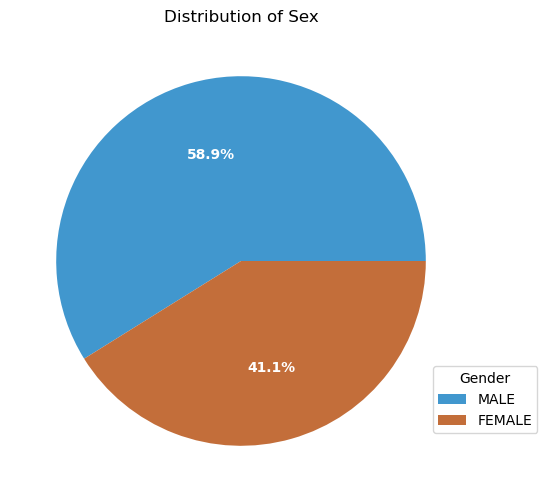

In [14]:
# Create pie chart of gender distribution


# Calculate gender counts
gender_counts = df_cans['GENDER'].value_counts()

# Define colors for each gender
colors = {'MALE': '#4197ce', 'FEMALE': '#c36e3a'}

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct=lambda pct: f'{pct:.1f}%',
        colors=[colors[gender] for gender in gender_counts.index],
        textprops={'color': 'white', 'weight': 'bold'})
plt.title('Distribution of Sex')
plt.legend(gender_counts.index, title='Gender', loc='center left', bbox_to_anchor=(0.9, 0, 0.5, 0.4))
plt.show()


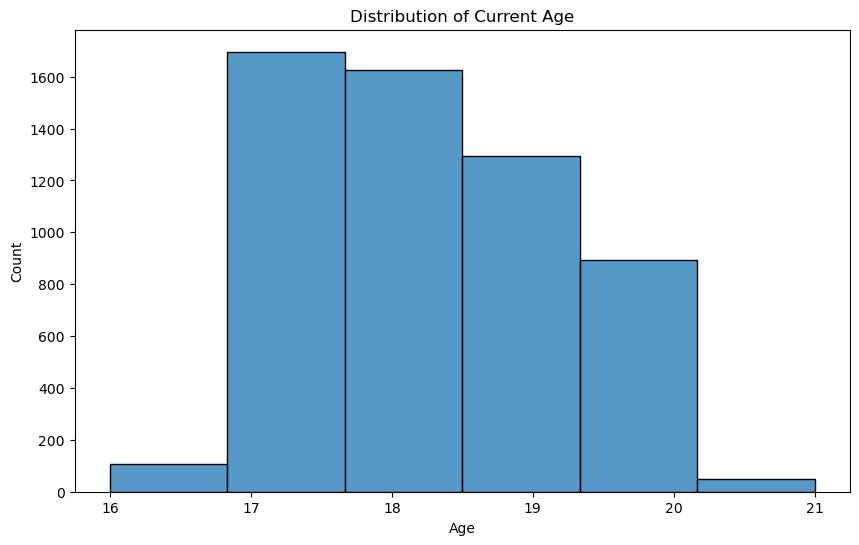

In [15]:
# Create frequency chart of age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cans, x='CURRENT AGE', bins=6)
plt.title('Distribution of Current Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


In [ ]:
# Mental Health categories
mh_behavioral_impulse_control = [
    'Decision-Making (Judgement)',
    'Impulsivity/Hyperactivity', 
    'School Behavior',
    'Substance Use'
]

mh_cultural_spiritual_engagement = [
    'Spiritual/Religious',
    'Traditions And Rituals',
    'Youth Involvement With Care'
]

mh_mood_emotional_regulation = [
    'Anger Control',
    'Anxiety', 
    'Depression',
    'Emotional And/Or Physical Dysregulation',
    'Numbing'
]

mh_physical_medical = [
    'Medical/Physical'
]

mh_psychotic_thought = [
    'Psychosis (Thought Disorder)'
]

mh_risk_safety = [
    'Danger To Others',
    'Intentional Misbehavior',
    'Non-Suicidal Self-Injurious Behavior', 
    'Other Self-Harm (Recklessness)',
    'Suicide Risk'
]

mh_sexual_developmental = [
    'Sexual Aggression',
    'Sexual Development'
]

mh_trauma_stress = [
    'Adjustment To Trauma',
    'Cultural Stress',
    'Emotional Abuse',
    'Environmental Influences',
    'Medical Trauma', 
    'Sexual Abuse'
]

# Group Mental Health categories
mental_health_categories = {
    'Behavioral & Impulse Control': mh_behavioral_impulse_control,
    'Cultural, Spiritual, and Engagement Factors': mh_cultural_spiritual_engagement,
    'Mood & Emotional Regulation': mh_mood_emotional_regulation,
    'Physical & Medical': mh_physical_medical,
    'Psychotic & Thought Disturbances': mh_psychotic_thought,
    'Risk & Safety': mh_risk_safety,
    'Sexual & Developmental Concerns': mh_sexual_developmental,
    'Trauma & Stress-Related': mh_trauma_stress
}

# Supportive Adult Relationship categories
sar_family_relationships = [
    'Family Functioning', 
    'Family Strengths',
    'Relationship Permanence',
] 

sar_social_relationships = [
    'Community Life', 
    'Interpersonal/Social Connectedness', 
    'Natural Supports', 
    'Social Functioning'
]

sar_barriers_to_support = [
    'Attachment Difficulties',
    'Oppositional(Non-compliance with Authority)',
    'Neglect'
]

# Group Supportive Adult Relationship categories
supportive_adult_relationships = {
    'Family Relationships': sar_family_relationships,
    'Social Relationships': sar_social_relationships,
    'Barriers to Support': sar_barriers_to_support
}

# Housing Instability categories
hi_skills_readiness = [
    'Independent Living Skills',
]

hi_current_living_situation = [
    'Living Situation',
    'Youth Residential Stability' 
]

hi_barriers_risk = [
    'Physical Abuse', 
    'Runaway*'
]

# Housing Instability categories
housing_instability = {
    'Skills & Readiness': hi_skills_readiness,
    'Current Living Situation': hi_current_living_situation,
    'Barriers & Risks': hi_barriers_risk
}

# Group all categories
assessment_categories = {
    'Mental Health': mental_health_categories,
    'Supportive Adult Relationships': supportive_adult_relationships,
    'Housing Instability': housing_instability
}

### Bucket DF

In [57]:
# ---------- helpers (same as before) ----------
def _slug(s: str) -> str:
    s = re.sub(r"[^\w]+", "_", s.strip())
    return re.sub(r"_+", "_", s).strip("_")

def _iter_leaf_categories(mapping, prefix=None):
    prefix = prefix or []
    if isinstance(mapping, dict):
        for k, v in mapping.items():
            yield from _iter_leaf_categories(v, prefix + [k])
    elif isinstance(mapping, list):
        label = " / ".join(prefix)  # full path label
        yield (label, mapping)
    else:
        raise ValueError("Category tree must be dicts/lists of column names.")

def _norm(name: str) -> str:
    """Normalize a column name for matching: collapse whitespace, strip, casefold."""
    return re.sub(r"\s+", " ", str(name)).strip().casefold()

# ---------- flags: 1 if any >= 2; 0 if all observed == 0; NaN if no data ----------
def build_category_flags_ge2(df: pd.DataFrame, categories_root: dict) -> pd.DataFrame:
    """
    For each leaf category, compute an indicator:
      - 1 if any value >= 2 in that row among the category's columns
      - 0 if all observed values == 0 (and at least one non-NaN exists)
      - NaN if no data (all NaN or no matching columns exist)
    """
    out = {}

    for label, col_list in _iter_leaf_categories(categories_root):
        cols_exist = [c for c in col_list if c in df.columns]
        safe_col = _slug(label)

        if not cols_exist:
            out[safe_col] = pd.Series(np.nan, index=df.index)
            continue

        block = df[cols_exist].apply(pd.to_numeric, errors="coerce")

        any_ge2  = block.ge(2).any(axis=1)
        any_data = block.notna().any(axis=1)
        all_zero = (block.fillna(0).sum(axis=1) == 0) & any_data

        flag = pd.Series(np.nan, index=df.index)
        flag[all_zero] = 0
        flag[any_ge2]  = 1

        out[safe_col] = flag

    return pd.DataFrame(out, index=df.index)

# ---------- wrapper that ALSO includes your passthrough columns ----------
def build_category_flags_ge2_with_metadata(
    df: pd.DataFrame,
    categories_root: dict,
    passthrough_cols: list,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Returns a DataFrame with:
      - passthrough_cols (exact output names as provided)
      - >=2 flags per category
    Matching is case-insensitive and whitespace-normalized.
    Missing passthroughs are created as NaN to keep schema stable.
    """
    flags = build_category_flags_ge2(df, categories_root)

    # Map normalized -> actual df column
    actual_map = {_norm(c): c for c in df.columns}

    meta = pd.DataFrame(index=df.index)
    matched, missing = [], []

    for want_name in passthrough_cols:
        norm_want = _norm(want_name)
        if norm_want in actual_map:
            meta[want_name] = df[actual_map[norm_want]]
            matched.append((want_name, actual_map[norm_want]))
        else:
            meta[want_name] = np.nan
            missing.append(want_name)

    if verbose:
        if matched:
            print("Matched passthrough columns:")
            for out_name, src in matched:
                print(f"  {out_name}  ←  {src}")
        if missing:
            print("Missing passthrough columns (created as NaN):")
            for out_name in missing:
                print(f"  {out_name}")

    return pd.concat([meta, flags], axis=1)

# ---------- usage ----------
passthrough = [
    'PERSON ID', 'CURRENT AGE', 'COMMITMENT COUNTY', 'RESPONSIBLE COUNTY',
    'GENDER', 'REMOVAL ZIP CODE', 'PLACEMENT ZIP CODE',
    'LOCATION BEGIN DATE', 'LOCATION END DATE'
]

# df_cans and assessment_categories should already exist
df_ge2_flags = build_category_flags_ge2_with_metadata(
    df_cans,
    assessment_categories,
    passthrough_cols=passthrough,
    verbose=True
)

# Example peek:
# df_ge2_flags.head()


Matched passthrough columns:
  PERSON ID  ←  PERSON ID
  CURRENT AGE  ←  CURRENT AGE
  COMMITMENT COUNTY  ←  COMMITMENT COUNTY
  RESPONSIBLE COUNTY  ←  RESPONSIBLE COUNTY
  GENDER  ←  GENDER
  REMOVAL ZIP CODE  ←  REMOVAL ZIP CODE
  PLACEMENT ZIP CODE  ←  PLACEMENT ZIP CODE
  LOCATION BEGIN DATE  ←  LOCATION BEGIN DATE
  LOCATION END DATE  ←  LOCATION END DATE


In [58]:
df_ge2_flags.head()

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Mental_Health_Behavioral_Impulse_Control,Mental_Health_Cultural_Spiritual_and_Engagement_Factors,Mental_Health_Mood_Emotional_Regulation,Mental_Health_Physical_Medical,Mental_Health_Psychotic_Thought_Disturbances,Mental_Health_Risk_Safety,Mental_Health_Sexual_Developmental_Concerns,Mental_Health_Trauma_Stress_Related,Supportive_Adult_Relationships_Family_Relationships,Supportive_Adult_Relationships_Social_Relationships,Supportive_Adult_Relationships_Barriers_to_Support,Housing_Instability_Skills_Readiness,Housing_Instability_Current_Living_Situation,Housing_Instability_Barriers_Risks
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,0.0,NaN,0.0
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,0.0,0.0
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,1.0,1.0,1.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0


In [ ]:
# ---------- helpers ----------
def _slug(s: str) -> str:
    s = re.sub(r"[^\w]+", "_", s.strip())
    return re.sub(r"_+", "_", s).strip("_")

def _iter_leaf_categories(mapping, prefix=None):
    prefix = prefix or []
    if isinstance(mapping, dict):
        for k, v in mapping.items():
            yield from _iter_leaf_categories(v, prefix + [k])
    elif isinstance(mapping, list):
        label = " / ".join(prefix)  # full path label
        yield (label, mapping)
    else:
        raise ValueError("Category tree must be dicts/lists of column names.")

def _norm(name: str) -> str:
    """Normalize a column name for matching: collapse whitespace, strip, casefold."""
    return re.sub(r"\s+", " ", str(name)).strip().casefold()

# ---------- flags: 1 if any == 3; 0 if all observed == 0; NaN if no data ----------
def build_category_flags_extreme(df: pd.DataFrame, categories_root: dict) -> pd.DataFrame:
    out = {}

    for label, col_list in _iter_leaf_categories(categories_root):
        cols_exist = [c for c in col_list if c in df.columns]
        safe_col = _slug(label)

        if not cols_exist:
            out[safe_col] = pd.Series(np.nan, index=df.index)
            continue

        block = df[cols_exist].apply(pd.to_numeric, errors="coerce")

        any_eq3  = block.eq(3).any(axis=1)
        any_data = block.notna().any(axis=1)
        all_zero = (block.fillna(0).sum(axis=1) == 0) & any_data

        flag = pd.Series(np.nan, index=df.index)
        flag[all_zero] = 0
        flag[any_eq3]  = 1

        out[safe_col] = flag

    return pd.DataFrame(out, index=df.index)

# ---------- robust passthrough (case/space-insensitive) ----------
def build_category_flags_extreme_with_metadata(
    df: pd.DataFrame,
    categories_root: dict,
    passthrough_cols: list,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Returns a DataFrame with:
      - passthrough_cols (exact output names as provided)
      - extreme flags per category
    Matching is case-insensitive and whitespace-normalized.
    Missing passthroughs are created as NaN to keep schema stable.
    """
    flags = build_category_flags_extreme(df, categories_root)

    # Map normalized -> actual df column
    actual_map = {_norm(c): c for c in df.columns}

    meta = pd.DataFrame(index=df.index)
    matched, missing = [], []

    for want_name in passthrough_cols:
        norm_want = _norm(want_name)
        if norm_want in actual_map:
            meta[want_name] = df[actual_map[norm_want]]
            matched.append((want_name, actual_map[norm_want]))
        else:
            meta[want_name] = np.nan
            missing.append(want_name)

    if verbose:
        if matched:
            print("Matched passthrough columns:")
            for out_name, src in matched:
                print(f"  {out_name}  ←  {src}")
        if missing:
            print("Missing passthrough columns (created as NaN):")
            for out_name in missing:
                print(f"  {out_name}")

    return pd.concat([meta, flags], axis=1)

# ---------- usage ----------
passthrough = [
    'PERSON ID', 'CURRENT AGE', 'COMMITMENT COUNTY', 'RESPONSIBLE COUNTY',
    'GENDER', 'REMOVAL ZIP CODE', 'PLACEMENT ZIP CODE',
    'LOCATION BEGIN DATE', 'LOCATION END DATE'
]

# Build the final dataframe (uses df_cans and your assessment_categories)
df_extreme_flags = build_category_flags_extreme_with_metadata(
    df_cans,
    assessment_categories,
    passthrough_cols=passthrough,
    verbose=True
)

# Quick sanity check:
# df_extreme_flags.filter(passthrough).head()
# df_extreme_flags.head()


Matched passthrough columns:
  PERSON ID  ←  PERSON ID
  CURRENT AGE  ←  CURRENT AGE
  COMMITMENT COUNTY  ←  COMMITMENT COUNTY
  RESPONSIBLE COUNTY  ←  RESPONSIBLE COUNTY
  GENDER  ←  GENDER
  REMOVAL ZIP CODE  ←  REMOVAL ZIP CODE
  PLACEMENT ZIP CODE  ←  PLACEMENT ZIP CODE
  LOCATION BEGIN DATE  ←  LOCATION BEGIN DATE
  LOCATION END DATE  ←  LOCATION END DATE


In [56]:
df_extreme_flags.head()

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Mental_Health_Behavioral_Impulse_Control,Mental_Health_Cultural_Spiritual_and_Engagement_Factors,Mental_Health_Mood_Emotional_Regulation,Mental_Health_Physical_Medical,Mental_Health_Psychotic_Thought_Disturbances,Mental_Health_Risk_Safety,Mental_Health_Sexual_Developmental_Concerns,Mental_Health_Trauma_Stress_Related,Supportive_Adult_Relationships_Family_Relationships,Supportive_Adult_Relationships_Social_Relationships,Supportive_Adult_Relationships_Barriers_to_Support,Housing_Instability_Skills_Readiness,Housing_Instability_Current_Living_Situation,Housing_Instability_Barriers_Risks
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,0.0,0.0
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0


<h3 style="color:navy">For each Sub-Category create a risk table</h3>

In [17]:
# Create dataframes for Housing Instability categories
df_hi_skills_readiness = df_cans[['PERSON ID'] + hi_skills_readiness].copy()
df_hi_current_living_situation = df_cans[['PERSON ID'] + hi_current_living_situation].copy()
df_hi_barriers_risk = df_cans[['PERSON ID'] + hi_barriers_risk].copy()

# Create dataframes for Mental Health categories 
df_mh_behavioral_impulse_control = df_cans[['PERSON ID'] + mh_behavioral_impulse_control].copy() 
df_mh_cultural_spiritual_engagement = df_cans[['PERSON ID'] + mh_cultural_spiritual_engagement].copy()
df_mh_mood_emotional_regulation = df_cans[['PERSON ID'] + mh_mood_emotional_regulation].copy()
df_mh_physical_medical = df_cans[['PERSON ID'] + mh_physical_medical].copy()
df_mh_psychotic_thought = df_cans[['PERSON ID'] + mh_psychotic_thought].copy()
df_mh_risk_behaviors = df_cans[['PERSON ID'] + mh_risk_safety].copy()
df_mh_sexual_developmental = df_cans[['PERSON ID'] + mh_sexual_developmental].copy()
df_mh_trauma_stress = df_cans[['PERSON ID'] + mh_trauma_stress].copy()

# Create dataframes for Supportive Adult Relationships categories
df_sar_family_relationships = df_cans[['PERSON ID'] + sar_family_relationships].copy()
df_sar_social_relationships = df_cans[['PERSON ID'] + sar_social_relationships].copy()
df_sar_barriers_support = df_cans[['PERSON ID'] + sar_barriers_to_support].copy()

# Function to create high risk and extreme risk indicator columns
def add_risk_indicators(df):
    for col in df.columns:
        if col != 'PERSON ID':
            # Create high risk indicator, preserving nulls
            df[f'{col}_HIGH_RISK'] = df[col].apply(lambda x: 1 if x in ['2', '3'] else (0 if pd.notna(x) else None))
            
            # Create extreme risk indicator, preserving nulls 
            df[f'{col}_EXTREME_RISK'] = df[col].apply(lambda x: 1 if x == '3' else (0 if pd.notna(x) else None))
    return df

# Apply risk indicators to all dataframes
df_hi_skills_readiness = add_risk_indicators(df_hi_skills_readiness)
df_hi_current_living_situation = add_risk_indicators(df_hi_current_living_situation)
df_hi_barriers_risk = add_risk_indicators(df_hi_barriers_risk)

df_mh_behavioral_impulse_control = add_risk_indicators(df_mh_behavioral_impulse_control)
df_mh_cultural_spiritual_engagement = add_risk_indicators(df_mh_cultural_spiritual_engagement)
df_mh_mood_emotional_regulation = add_risk_indicators(df_mh_mood_emotional_regulation)
df_mh_physical_medical = add_risk_indicators(df_mh_physical_medical)
df_mh_psychotic_thought = add_risk_indicators(df_mh_psychotic_thought)
df_mh_risk_behaviors = add_risk_indicators(df_mh_risk_behaviors)
df_mh_sexual_developmental = add_risk_indicators(df_mh_sexual_developmental)
df_mh_trauma_stress = add_risk_indicators(df_mh_trauma_stress)

df_sar_family_relationships = add_risk_indicators(df_sar_family_relationships)
df_sar_social_relationships = add_risk_indicators(df_sar_social_relationships)
df_sar_barriers_support = add_risk_indicators(df_sar_barriers_support)


In [18]:
print("df_hi_skills_readiness shape:", df_hi_skills_readiness.shape)
print("df_hi_current_living_situation shape:", df_hi_current_living_situation.shape)
print("df_hi_barriers_risk shape:", df_hi_barriers_risk.shape)

print("\ndf_mh_behavioral_impulse_control shape:", df_mh_behavioral_impulse_control.shape)
print("df_mh_cultural_spiritual_engagement shape:", df_mh_cultural_spiritual_engagement.shape) 
print("df_mh_mood_emotional_regulation shape:", df_mh_mood_emotional_regulation.shape)
print("df_mh_physical_medical shape:", df_mh_physical_medical.shape)
print("df_mh_psychotic_thought shape:", df_mh_psychotic_thought.shape)
print("df_mh_risk_behaviors shape:", df_mh_risk_behaviors.shape)
print("df_mh_sexual_developmental shape:", df_mh_sexual_developmental.shape)
print("df_mh_trauma_stress shape:", df_mh_trauma_stress.shape)

print("\ndf_sar_family_relationships shape:", df_sar_family_relationships.shape)
print("df_sar_social_relationships shape:", df_sar_social_relationships.shape)
print("df_sar_barriers_support shape:", df_sar_barriers_support.shape)


df_hi_skills_readiness shape: (5667, 4)
df_hi_current_living_situation shape: (5667, 7)
df_hi_barriers_risk shape: (5667, 7)

df_mh_behavioral_impulse_control shape: (5667, 13)
df_mh_cultural_spiritual_engagement shape: (5667, 10)
df_mh_mood_emotional_regulation shape: (5667, 16)
df_mh_physical_medical shape: (5667, 4)
df_mh_psychotic_thought shape: (5667, 4)
df_mh_risk_behaviors shape: (5667, 16)
df_mh_sexual_developmental shape: (5667, 7)
df_mh_trauma_stress shape: (5667, 19)

df_sar_family_relationships shape: (5667, 10)
df_sar_social_relationships shape: (5667, 13)
df_sar_barriers_support shape: (5667, 10)


<h3 style="color:navy">Create High Risk df for each indicator</h3>

In [20]:
### For each 'indicator' in df_cans, create a high risk indicator column (score of 2 or 3)
df_high_risk = df_cans.copy()
for col in df_cans.columns:
    if col not in ['PERSON ID', 'CURRENT AGE', 'COMMITMENT COUNTY', 'RESPONSIBLE COUNTY', 'GENDER', 'REMOVAL ZIP CODE', 'PLACEMENT ZIP CODE', 'LOCATION BEGIN DATE', 'LOCATION END DATE']:
        df_cans[col] = df_cans[col].astype(float)
        df_high_risk[col] = df_cans[col].apply(lambda x: 1 if x >= 2 else 0 if pd.notna(x) else np.nan)

In [ ]:
### Import county-region mapping
df_region = pd.read_excel('../data/tn_county_region.xlsx')

### Merge df_region with df_high_risk
# First, create final "county" column in df_high_risk
df_high_risk['County'] = df_high_risk.apply(lambda x: x['COMMITMENT COUNTY'] if pd.isna(x['RESPONSIBLE COUNTY']) or x['RESPONSIBLE COUNTY'] == 'Unassigned' else x['RESPONSIBLE COUNTY'], axis=1)
df_high_risk_all = df_high_risk.merge(df_region, left_on='County', right_on='County', how='left')

### For Buckets

In [59]:
### Import county-region mapping
df_region = pd.read_excel('../data/tn_county_region.xlsx')

### Merge df_region with df_high_risk
# First, create final "county" column in df_high_risk
df_ge2_flags['County'] = df_ge2_flags.apply(lambda x: x['COMMITMENT COUNTY'] if pd.isna(x['RESPONSIBLE COUNTY']) or x['RESPONSIBLE COUNTY'] == 'Unassigned' else x['RESPONSIBLE COUNTY'], axis=1)
df_high_risk_buckets = df_ge2_flags.merge(df_region, left_on='County', right_on='County', how='left')

In [60]:
df_high_risk_buckets.head()

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Mental_Health_Behavioral_Impulse_Control,Mental_Health_Cultural_Spiritual_and_Engagement_Factors,Mental_Health_Mood_Emotional_Regulation,Mental_Health_Physical_Medical,Mental_Health_Psychotic_Thought_Disturbances,Mental_Health_Risk_Safety,Mental_Health_Sexual_Developmental_Concerns,Mental_Health_Trauma_Stress_Related,Supportive_Adult_Relationships_Family_Relationships,Supportive_Adult_Relationships_Social_Relationships,Supportive_Adult_Relationships_Barriers_to_Support,Housing_Instability_Skills_Readiness,Housing_Instability_Current_Living_Situation,Housing_Instability_Barriers_Risks,County,Region
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,0.0,NaN,0.0,Madison,West
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,Sullivan,East
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,0.0,0.0,Warren,Middle
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,1.0,1.0,1.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,Hamilton,East
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,Davidson,Middle


<h3 style="color:navy">Create Extreme Risk df for each indicator</h3>

In [57]:
### For each 'indicator' in df_cans, create an extreme risk indicator column (score of 3)
df_extreme_risk = df_cans.copy()
for col in df_cans.columns:
    if col not in ['PERSON ID', 'CURRENT AGE', 'COMMITMENT COUNTY', 'RESPONSIBLE COUNTY', 'GENDER', 'REMOVAL ZIP CODE', 'PLACEMENT ZIP CODE', 'LOCATION BEGIN DATE', 'LOCATION END DATE']:
        df_cans[col] = df_cans[col].astype(float)
        df_extreme_risk[col] = df_cans[col].apply(lambda x: 1 if x == 3 else 0 if pd.notna(x) else np.nan)

In [58]:
### Merge df_region with df_extreme_risk
# First, create final "county" column in df_extreme_risk
df_extreme_risk['County'] = df_extreme_risk.apply(lambda x: x['COMMITMENT COUNTY'] if pd.isna(x['RESPONSIBLE COUNTY']) or x['RESPONSIBLE COUNTY'] == 'Unassigned' else x['RESPONSIBLE COUNTY'], axis=1)
df_extreme_risk = df_extreme_risk.merge(df_region, left_on='County', right_on='County', how='left')

In [61]:
### Merge df_region with df_extreme_risk
# First, create final "county" column in df_extreme_risk
df_extreme_flags['County'] = df_extreme_flags.apply(lambda x: x['COMMITMENT COUNTY'] if pd.isna(x['RESPONSIBLE COUNTY']) or x['RESPONSIBLE COUNTY'] == 'Unassigned' else x['RESPONSIBLE COUNTY'], axis=1)
df_extreme_risk_buckets = df_extreme_flags.merge(df_region, left_on='County', right_on='County', how='left')

In [60]:
df_high_risk.to_csv('../data/bdaic created tables/df_high_risk.csv', index = False) 
df_extreme_risk.to_csv('../data/bdaic created tables/df_extreme_risk.csv', index = False) 

In [62]:
df_high_risk_buckets.to_csv('../data/bdaic created tables/df_high_risk_buckets.csv', index = False) 
df_extreme_risk_buckets.to_csv('../data/bdaic created tables/df_extreme_risk_buckets.csv', index = False) 

In [63]:
df_cans.head(15)

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Decision-Making (Judgement),Impulsivity/Hyperactivity,School Behavior,Substance Use,Spiritual/Religious,Traditions And Rituals,Youth Involvement With Care,Anger Control,Anxiety,Depression,Emotional And/Or Physical Dysregulation,Numbing,Medical/Physical,Psychosis (Thought Disorder),Danger To Others,Intentional Misbehavior,Non-Suicidal Self-Injurious Behavior,Other Self-Harm (Recklessness),Suicide Risk,Sexual Aggression,Sexual Development,Adjustment To Trauma,Cultural Stress,Emotional Abuse,Environmental Influences,Medical Trauma,Sexual Abuse,Attachment Difficulties,Community Life,Family Functioning,Family Strengths,Interpersonal/Social Connectedness,Natural Supports,Neglect,Oppositional(Non-compliance with Authority),Relationship Permanence,Social Functioning,Independent Living Skills,Living Situation,Physical Abuse,Runaway*,Youth Residential Stability
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,2.0,0.0,1.0,2.0,3.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,2.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,3997434,19,Knox,Knox,MALE,30135,30135,2022-07-21,2023-06-17,2.0,2.0,2.0,0.0,3.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0
6,4186760,20,Shelby,Shelby,MALE,38485,38485,2022-05-19,2022-11-18,2.0,2.0,2.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
7,4262218,21,Shelby,Shelby,MALE,37725,37725,2022-06-09,2022-10-06,1.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
8,4451688,20,Hamilton,Hamilton,MALE,38401,38401,2022-06-23,2022-10-03,2.0,1.0,0.0,2.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,3.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,3.0,0.0
9,4492160,21,Shelby,Shelby,MALE,38105,38105,2021-09-29,2021-10-06,1.0,2.0,1.0,0.0,2.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,0.0,0.0,1.0


In [46]:
df_high_risk.head(15)

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Decision-Making (Judgement),Impulsivity/Hyperactivity,School Behavior,Substance Use,Spiritual/Religious,Traditions And Rituals,Youth Involvement With Care,Anger Control,Anxiety,Depression,Emotional And/Or Physical Dysregulation,Numbing,Medical/Physical,Psychosis (Thought Disorder),Danger To Others,Intentional Misbehavior,Non-Suicidal Self-Injurious Behavior,Other Self-Harm (Recklessness),Suicide Risk,Sexual Aggression,Sexual Development,Adjustment To Trauma,Cultural Stress,Emotional Abuse,Environmental Influences,Medical Trauma,Sexual Abuse,Attachment Difficulties,Community Life,Family Functioning,Family Strengths,Interpersonal/Social Connectedness,Natural Supports,Neglect,Oppositional(Non-compliance with Authority),Relationship Permanence,Social Functioning,Independent Living Skills,Living Situation,Physical Abuse,Runaway*,Youth Residential Stability,County,Region
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,NaN,0,0,0,1,0,0,0,1,1,0,0,0,0.0,0,0,0,0.0,Madison,West
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,NaN,0,0,0,0,0,1,0,1,1,0,0,0,0.0,0,0,0,0.0,Sullivan,East
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,Warren,Middle
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,1,0,0,1,1,0,0.0,1,1,1,0.0,0.0,0,0,1,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,1,0,0,1,1,0,0,1,1,1.0,0,0,0,1.0,Hamilton,East
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,1,1,0,1,0,0,0.0,0,0,0,0.0,0.0,1,0,1,0,0,1,0,0,0,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,0,0,0.0,Davidson,Middle
5,3997434,19,Knox,Knox,MALE,30135,30135,2022-07-21,2023-06-17,1,1,1,0,1,0,1.0,1,1,1,1.0,1.0,0,0,1,1,0,0,0,0,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0.0,1,0,0,0.0,Knox,East
6,4186760,20,Shelby,Shelby,MALE,38485,38485,2022-05-19,2022-11-18,1,1,1,0,1,0,0.0,0,0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,1,0.0,0,0,0,0.0,Shelby,West
7,4262218,21,Shelby,Shelby,MALE,37725,37725,2022-06-09,2022-10-06,0,0,0,0,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,1.0,0,0,0,1,0,0,0,1,0,0,0,0,0.0,0,0,0,0.0,Shelby,West
8,4451688,20,Hamilton,Hamilton,MALE,38401,38401,2022-06-23,2022-10-03,1,0,0,1,1,0,0.0,1,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,1.0,0,0,0,1,1,1,0,1,0,0,1,1,0.0,1,0,1,0.0,Hamilton,East
9,4492160,21,Shelby,Shelby,MALE,38105,38105,2021-09-29,2021-10-06,0,1,0,0,1,0,0.0,1,0,1,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,1,1,1,0,0,0,0,1,1,1.0,0,0,0,0.0,Shelby,West


In [59]:
df_extreme_risk.head(15)

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Decision-Making (Judgement),Impulsivity/Hyperactivity,School Behavior,Substance Use,Spiritual/Religious,Traditions And Rituals,Youth Involvement With Care,Anger Control,Anxiety,Depression,Emotional And/Or Physical Dysregulation,Numbing,Medical/Physical,Psychosis (Thought Disorder),Danger To Others,Intentional Misbehavior,Non-Suicidal Self-Injurious Behavior,Other Self-Harm (Recklessness),Suicide Risk,Sexual Aggression,Sexual Development,Adjustment To Trauma,Cultural Stress,Emotional Abuse,Environmental Influences,Medical Trauma,Sexual Abuse,Attachment Difficulties,Community Life,Family Functioning,Family Strengths,Interpersonal/Social Connectedness,Natural Supports,Neglect,Oppositional(Non-compliance with Authority),Relationship Permanence,Social Functioning,Independent Living Skills,Living Situation,Physical Abuse,Runaway*,Youth Residential Stability,County,Region
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,Madison,West
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,NaN,0,0,0,0,0,0,0,1,1,0,0,0,0.0,0,0,0,0.0,Sullivan,East
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,Warren,Middle
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,0,0,0,0,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0.0,Hamilton,East
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,1,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,0,0,0.0,Davidson,Middle
5,3997434,19,Knox,Knox,MALE,30135,30135,2022-07-21,2023-06-17,0,0,0,0,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0,0,0,0.0,Knox,East
6,4186760,20,Shelby,Shelby,MALE,38485,38485,2022-05-19,2022-11-18,0,0,0,0,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0.0,Shelby,West
7,4262218,21,Shelby,Shelby,MALE,37725,37725,2022-06-09,2022-10-06,0,0,0,0,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0.0,Shelby,West
8,4451688,20,Hamilton,Hamilton,MALE,38401,38401,2022-06-23,2022-10-03,0,0,0,0,1,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0.0,0,0,1,0.0,Hamilton,East
9,4492160,21,Shelby,Shelby,MALE,38105,38105,2021-09-29,2021-10-06,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,1,1,0,0,0,0,1,0,0.0,0,0,0,0.0,Shelby,West


In [56]:
### Create interactive pie chart with filters for county, gender, age and selected indicator
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Get unique values for filters
counties = sorted(df_high_risk['RESPONSIBLE COUNTY'].unique())
genders = sorted(df_high_risk['GENDER'].unique())
regions = sorted(df_high_risk['Region'].unique())
indicators = [col for col in df_high_risk.columns if col not in ['PERSON ID', 'CURRENT AGE', 'COMMITMENT COUNTY', 'RESPONSIBLE COUNTY', 'GENDER', 'REMOVAL ZIP CODE', 'PLACEMENT ZIP CODE', 'LOCATION BEGIN DATE', 'LOCATION END DATE']]

# Create widgets
county_widget = widgets.SelectMultiple(
    options=counties,
    description='County:',
    disabled=False
)

gender_widget = widgets.SelectMultiple(
    options=genders, 
    description='Gender:',
    disabled=False
)

region_widget = widgets.SelectMultiple(
    options=regions,
    description='Region:',
    disabled=False
)

age_range = widgets.IntRangeSlider(
    value=[df_high_risk['CURRENT AGE'].min(), df_high_risk['CURRENT AGE'].max()],
    min=df_high_risk['CURRENT AGE'].min(),
    max=df_high_risk['CURRENT AGE'].max(),
    step=1,
    description='Age Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

indicator_widget = widgets.Dropdown(
    options=indicators,
    description='Indicator:',
    disabled=False,
)

# Add reset button
reset_button = widgets.Button(
    description='Reset Filters',
    button_style='warning'
)

def update_chart(county, gender, region, age_min, age_max, indicator):
    # Filter data based on selections
    mask = df_high_risk['CURRENT AGE'].between(age_min, age_max)
    
    if len(county) > 0:
        mask = mask & df_high_risk['RESPONSIBLE COUNTY'].isin(county)
    if len(gender) > 0:
        mask = mask & df_high_risk['GENDER'].isin(gender)
    if len(region) > 0:
        mask = mask & df_high_risk['Region'].isin(region)
        
    filtered_df = df_high_risk[mask]
    
    # Calculate counts and percentages
    value_counts = filtered_df[indicator].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total * 100).round(1)
    
    # Create labels with counts
    high_risk_count = value_counts.get(1, 0)
    low_risk_count = value_counts.get(0, 0)
    labels = [f'High Risk ({high_risk_count} youth)', f'Low/No Risk ({low_risk_count} youth)']
    values = [percentages.get(1, 0), percentages.get(0, 0)]
    
    # Create pie chart
    fig = px.pie(values=values, names=labels, 
                 title=f'Risk Distribution for {indicator}',
                 color_discrete_sequence=['#6B7B8C', '#8B9DAF'])
    fig.update_traces(textinfo='percent+label')
    fig.show()

def reset_filters(b):
    county_widget.value = ()
    gender_widget.value = ()
    region_widget.value = ()
    age_range.value = (df_high_risk['CURRENT AGE'].min(), df_high_risk['CURRENT AGE'].max())
    indicator_widget.value = indicators[0]

# Connect reset button to function
reset_button.on_click(reset_filters)

# Create interactive widget
interactive_chart = widgets.interactive(
    update_chart,
    county=county_widget,
    gender=gender_widget,
    region=region_widget,
    age_min=widgets.fixed(age_range.value[0]),
    age_max=widgets.fixed(age_range.value[1]),
    indicator=indicator_widget
)

# Display widgets and initial chart
display(age_range)
display(reset_button)
display(interactive_chart)


IntRangeSlider(value=(16, 21), continuous_update=False, description='Age Range:', max=21, min=16)

Button(button_style='warning', description='Reset Filters', style=ButtonStyle())

interactive(children=(SelectMultiple(description='County:', options=('Anderson', 'Bedford', 'Benton', 'Bledsoe…

In [38]:
### Display percentage of high risk youth by gender for Runaway* and Physical Abuse
high_risk_by_gender = df_high_risk.groupby('GENDER')[['Runaway*', 'Physical Abuse']].mean().mul(100).round(1)
print("\nPercentage of High Risk Youth by Gender:")
print(high_risk_by_gender.astype(str) + '%')



Percentage of High Risk Youth by Gender:
       Runaway* Physical Abuse
GENDER                        
FEMALE    13.0%          25.9%
MALE      12.1%          18.0%


<h3 style="color:navy">County-Level Table</h3>

In [ ]:
df_tmp = df_cans[['PERSON ID','COMMITMENT COUNTY','RESPONSIBLE COUNTY']].copy() 
df_tmp['County'] = df_tmp.apply(lambda x: x['RESPONSIBLE COUNTY'] if pd.notna(x['RESPONSIBLE COUNTY']) and x['RESPONSIBLE COUNTY'] != 'Unassigned' else x['COMMITMENT COUNTY'], axis=1)


In [ ]:
### Create a df_tmp_high table that has the "high risk" indicators for each sub-category dataframe merged 
df_tmp_high = df_tmp.merge(
    df_hi_skills_readiness[['PERSON ID', 'Independent Living Skills_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_hi_current_living_situation[['PERSON ID', 'Living Situation_HIGH_RISK', 'Youth Residential Stability_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_hi_barriers_risk[['PERSON ID', 'Physical Abuse_HIGH_RISK', 'Runaway*_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_behavioral_impulse_control[['PERSON ID', 'Decision-Making (Judgement)_HIGH_RISK', 'Impulsivity/Hyperactivity_HIGH_RISK', 'School Behavior_HIGH_RISK', 'Substance Use_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_cultural_spiritual_engagement[['PERSON ID', 'Spiritual/Religious_HIGH_RISK', 'Traditions And Rituals_HIGH_RISK', 'Youth Involvement With Care_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_mood_emotional_regulation[['PERSON ID', 'Anger Control_HIGH_RISK', 'Anxiety_HIGH_RISK', 'Depression_HIGH_RISK', 'Emotional And/Or Physical Dysregulation_HIGH_RISK', 'Numbing_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_physical_medical[['PERSON ID', 'Medical/Physical_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_psychotic_thought[['PERSON ID', 'Psychosis (Thought Disorder)_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_risk_behaviors[['PERSON ID', 'Danger To Others_HIGH_RISK', 'Intentional Misbehavior_HIGH_RISK', 'Non-Suicidal Self-Injurious Behavior_HIGH_RISK', 'Other Self-Harm (Recklessness)_HIGH_RISK', 'Suicide Risk_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_sexual_developmental[['PERSON ID', 'Sexual Aggression_HIGH_RISK', 'Sexual Development_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_mh_trauma_stress[['PERSON ID', 'Adjustment To Trauma_HIGH_RISK', 'Cultural Stress_HIGH_RISK', 'Emotional Abuse_HIGH_RISK', 'Environmental Influences_HIGH_RISK', 'Medical Trauma_HIGH_RISK', 'Sexual Abuse_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_sar_family_relationships[['PERSON ID', 'Family Functioning_HIGH_RISK', 'Family Strengths_HIGH_RISK', 'Relationship Permanence_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_sar_social_relationships[['PERSON ID', 'Community Life_HIGH_RISK', 'Interpersonal/Social Connectedness_HIGH_RISK', 'Natural Supports_HIGH_RISK', 'Social Functioning_HIGH_RISK']], 
    on='PERSON ID'
).merge(
    df_sar_barriers_support[['PERSON ID', 'Attachment Difficulties_HIGH_RISK', 'Oppositional(Non-compliance with Authority)_HIGH_RISK', 'Neglect_HIGH_RISK']], 
    on='PERSON ID'
)



In [ ]:
print(df_tmp_high.shape)
df_tmp_high.head(10)

In [ ]:
# Calculate percentage of high risk youth by county
agg_dict = {}
agg_dict['PERSON ID'] = 'size'
for col in df_tmp_high.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'PERSON ID':
        agg_dict[col] = 'mean' # mean will calculate % since values are 0/1

df_county_high = df_tmp_high.groupby('County').agg(agg_dict).reset_index()
df_county_high = df_county_high.rename(columns={'PERSON ID': 'n_youth'})


In [ ]:
df_county_high['n_youth'].hist(bins=50)

<h3 style="color:navy">Map County Data</h3>

In [65]:
### Import County Shapefiles
shapefile_path = '../data/bdaic created tables/tl_2024_us_county/'
shapefile = 'tl_2024_us_county.shp' 

# Load shapefile
gdf = gpd.read_file(shapefile_path + shapefile)

# Filter on TN 
gdf = gdf[gdf['STATEFP'] == '47']

# Merge with county_high dataframe
gdf = gdf.merge(df_extreme_risk_buckets, left_on='NAME', right_on='County', how='left')





In [66]:
df_extreme_risk_buckets.head()

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Mental_Health_Behavioral_Impulse_Control,Mental_Health_Cultural_Spiritual_and_Engagement_Factors,Mental_Health_Mood_Emotional_Regulation,Mental_Health_Physical_Medical,Mental_Health_Psychotic_Thought_Disturbances,Mental_Health_Risk_Safety,Mental_Health_Sexual_Developmental_Concerns,Mental_Health_Trauma_Stress_Related,Supportive_Adult_Relationships_Family_Relationships,Supportive_Adult_Relationships_Social_Relationships,Supportive_Adult_Relationships_Barriers_to_Support,Housing_Instability_Skills_Readiness,Housing_Instability_Current_Living_Situation,Housing_Instability_Barriers_Risks,County,Region
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,Madison,West
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,Sullivan,East
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,0.0,0.0,Warren,Middle
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,Hamilton,East
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,0.0,NaN,1.0,0.0,0.0,0.0,Davidson,Middle


In [ ]:
# Create interactive choropleth map with dropdown selector
import plotly.express as px
import plotly.graph_objects as go

# Get list of high risk indicators (columns ending in _HIGH_RISK)
Extreme_risk_cols = [
    col for col in df_extreme_risk_buckets.columns
    if re.match(r'^(Mental_Health|Supportive_Adult_Relationships|Housing_Instability)_', col)
]
# Create a list of traces for each indicator
traces = []
for col in Extreme_risk_cols:
    trace = go.Choropleth(
        geojson=gdf.geometry.__geo_interface__,
        locations=gdf.index,
        z=gdf[col].values,
        colorscale="Viridis", 
        name=col.replace('_HIGH_RISK','').replace('_',' '),
        showscale=True if col == Extreme_risk_cols[0] else False,
        visible=True if col == Extreme_risk_cols[0] else False,
        hovertemplate="<b>%{hovertext}</b><br>" +
                     "n_youth: %{customdata[0]}<br>" +
                     "Percent High Risk: %{customdata[1]:.1%}<br>" +
                     "<extra></extra>",
        hovertext=gdf['NAME'],
        customdata=gdf[['n_youth', col]].values,
        colorbar=dict(
            title="Percent High Risk",
            tickformat=".1%"
        )
    )
    traces.append(trace)

# Create figure with all traces
fig = go.Figure(data=traces)

# Update layout
fig.update_layout(
    width=1200,
    height=800,
    title_x=0.5,
    title_y=0.98,
    title=f"High Risk Youth by County - {Extreme_risk_cols[0].replace('_HIGH_RISK','').replace('_',' ')}",
    updatemenus=[{
        'buttons': [
            {'args': [{'visible': [i == j for j in range(len(high_risk_cols))]},
                     {'title': f"High Risk Youth by County - {col.replace('_HIGH_RISK','').replace('_',' ')}"}],
             'label': col.replace('_HIGH_RISK','').replace('_',' '),
             'method': 'update'}
            for i, col in enumerate(high_risk_cols)
        ],
        'direction': 'down',
        'showactive': True,
        'x': 0.1,
        'y': 0.95
    }]
)

fig.update_geos(
    fitbounds="locations",
    visible=False
)

fig.show()


In [ ]:
df_county_high[df_county_high['County'] == 'Shelby']

### Bucket mapping

<h3 style="color:navy">Folium Map</h3>

In [ ]:
def create_tn_counties_map(gdf, selected_variable):
    """
    Create a choropleth map of Tennessee counties with the selected variable
    
    Parameters:
    gdf: GeoDataFrame with Tennessee county data
    selected_variable: str, column name to visualize
    """
    
    # Calculate the center of Tennessee for map centering
    bounds = gdf.total_bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=7,
        tiles='OpenStreetMap'
    )
    
    # Get the data for the selected variable
    if selected_variable not in gdf.columns:
        print(f"Variable '{selected_variable}' not found in the dataset")
        return m
    
    # Handle missing values
    data_series = gdf[selected_variable].fillna(0)
    
    # Add choropleth layer
    folium.Choropleth(
        geo_data=gdf,
        data=gdf,
        columns=['index', selected_variable] if 'index' in gdf.columns else [gdf.index.name or 'index', selected_variable],
        key_on='feature.properties.index' if 'index' in gdf.columns else 'feature.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=selected_variable,
        bins=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],  # Fixed bins from 0% to 100%
        vmin=0.0,  # Force minimum to 0%
        vmax=1.0   # Force maximum to 100%
    ).add_to(m)
    
    # Add county labels and tooltips
    for idx, row in gdf.iterrows():
        # Get county name (adjust this based on your column names)
        county_name = ''
        possible_name_cols = ['NAME', 'County', 'COUNTY', 'name', 'county', 'County_Name']
        for col in possible_name_cols:
            if col in gdf.columns:
                county_name = row[col]
                break
        
        # Create popup text with percentage formatting and n_youth
        popup_text = f"""
        <b>{county_name}</b><br>
        {selected_variable}: {row[selected_variable]:.1%}<br>
        Number of Youth: {row['n_youth']}
        """
        
        # Add tooltip with percentage formatting and n_youth
        folium.GeoJson(
            row.geometry,
            style_function=lambda x: {
                'fillColor': 'transparent',
                'color': 'transparent',
                'weight': 0
            },
            popup=folium.Popup(popup_text, max_width=200),
            tooltip=f"{county_name}: {row[selected_variable]:.1%} ({row['n_youth']} youth)"
        ).add_to(m)
    
    # Fit map to bounds
    m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])
    
    return m

def interactive_map_widget(gdf, display_cols=None):
    """
    Create interactive widget for variable selection
    
    Parameters:
    gdf: GeoDataFrame with Tennessee county data
    display_cols: list of column names to include in dropdown (optional)
    """
    # Get available columns
    if display_cols is None:
        # Get numeric and categorical columns (exclude geometry)
        available_columns = [col for col in gdf.columns if col != 'geometry']
    else:
        # Use provided display columns that exist in the dataframe
        available_columns = [col for col in display_cols if col in gdf.columns]
    
    # Create dropdown widget
    variable_dropdown = Dropdown(
        options=available_columns,
        value=available_columns[0] if available_columns else None,
        description='Variable:',
        style={'description_width': 'initial'}
    )
    
    def update_map(selected_variable):
        if selected_variable:
            map_obj = create_tn_counties_map(gdf, selected_variable)
            display(map_obj)
    
    # Create interactive widget
    interact(update_map, selected_variable=variable_dropdown)

# Main execution
def create_interactive_tn_map(gdf, display_cols=None):
    """
    Main function to create the interactive Tennessee counties map
    
    Parameters:
    gdf: GeoDataFrame with Tennessee county data
    display_cols: list of column names to include in dropdown (optional)
    
    Usage:
    create_interactive_tn_map(gdf)  # Uses all available columns
    create_interactive_tn_map(gdf, ['population', 'median_income'])  # Uses only specified columns
    """
    
    # Ensure the GeoDataFrame has a proper index for choropleth
    if gdf.index.name is None:
        gdf = gdf.reset_index()
    
    # Display the interactive widget
    print("Tennessee Counties Interactive Map")
    print("Select a variable from the dropdown to visualize:")
    interactive_map_widget(gdf, display_cols)


In [ ]:

### List of columns to display
display_cols = ['Independent Living Skills_HIGH_RISK',
       'Living Situation_HIGH_RISK', 'Youth Residential Stability_HIGH_RISK',
       'Physical Abuse_HIGH_RISK', 'Runaway*_HIGH_RISK',
       'Decision-Making (Judgement)_HIGH_RISK',
       'Impulsivity/Hyperactivity_HIGH_RISK', 'School Behavior_HIGH_RISK',
       'Substance Use_HIGH_RISK', 'Spiritual/Religious_HIGH_RISK',
       'Traditions And Rituals_HIGH_RISK',
       'Youth Involvement With Care_HIGH_RISK', 'Anger Control_HIGH_RISK',
       'Anxiety_HIGH_RISK', 'Depression_HIGH_RISK',
       'Emotional And/Or Physical Dysregulation_HIGH_RISK',
       'Numbing_HIGH_RISK', 'Medical/Physical_HIGH_RISK',
       'Psychosis (Thought Disorder)_HIGH_RISK', 'Danger To Others_HIGH_RISK',
       'Intentional Misbehavior_HIGH_RISK',
       'Non-Suicidal Self-Injurious Behavior_HIGH_RISK',
       'Other Self-Harm (Recklessness)_HIGH_RISK', 'Suicide Risk_HIGH_RISK',
       'Sexual Aggression_HIGH_RISK', 'Sexual Development_HIGH_RISK',
       'Adjustment To Trauma_HIGH_RISK', 'Cultural Stress_HIGH_RISK',
       'Emotional Abuse_HIGH_RISK', 'Environmental Influences_HIGH_RISK',
       'Medical Trauma_HIGH_RISK', 'Sexual Abuse_HIGH_RISK',
       'Family Functioning_HIGH_RISK', 'Family Strengths_HIGH_RISK',
       'Relationship Permanence_HIGH_RISK', 'Community Life_HIGH_RISK',
       'Interpersonal/Social Connectedness_HIGH_RISK',
       'Natural Supports_HIGH_RISK', 'Social Functioning_HIGH_RISK',
       'Attachment Difficulties_HIGH_RISK',
       'Oppositional(Non-compliance with Authority)_HIGH_RISK',
       'Neglect_HIGH_RISK']


### Execute Folium Map function
create_interactive_tn_map(gdf, display_cols)  


# ARCGIS map

In [75]:
df_high_risk_buckets.head()

,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Mental_Health_Behavioral_Impulse_Control,Mental_Health_Cultural_Spiritual_and_Engagement_Factors,Mental_Health_Mood_Emotional_Regulation,Mental_Health_Physical_Medical,Mental_Health_Psychotic_Thought_Disturbances,Mental_Health_Risk_Safety,Mental_Health_Sexual_Developmental_Concerns,Mental_Health_Trauma_Stress_Related,Supportive_Adult_Relationships_Family_Relationships,Supportive_Adult_Relationships_Social_Relationships,Supportive_Adult_Relationships_Barriers_to_Support,Housing_Instability_Skills_Readiness,Housing_Instability_Current_Living_Situation,Housing_Instability_Barriers_Risks,County,Region
0,353258,17,Madison,Madison,MALE,37040,37040,2023-06-13,2024-05-25,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,1.0,0.0,NaN,0.0,Madison,West
1,706512,17,Sullivan,Sullivan,FEMALE,37642,37642,2024-11-18,NaT,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,Sullivan,East
2,1348374,17,Warren,Warren,FEMALE,37110,37110,2023-06-02,2023-09-30,NaN,NaN,NaN,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,NaN,0.0,0.0,Warren,Middle
3,2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,1.0,1.0,1.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,Hamilton,East
4,3965628,21,Davidson,Davidson,MALE,37725,37725,2021-12-22,2022-08-31,1.0,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,Davidson,Middle


In [76]:
gdf.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,PERSON ID,CURRENT AGE,COMMITMENT COUNTY,RESPONSIBLE COUNTY,GENDER,REMOVAL ZIP CODE,PLACEMENT ZIP CODE,LOCATION BEGIN DATE,LOCATION END DATE,Mental_Health_Behavioral_Impulse_Control,Mental_Health_Cultural_Spiritual_and_Engagement_Factors,Mental_Health_Mood_Emotional_Regulation,Mental_Health_Physical_Medical,Mental_Health_Psychotic_Thought_Disturbances,Mental_Health_Risk_Safety,Mental_Health_Sexual_Developmental_Concerns,Mental_Health_Trauma_Stress_Related,Supportive_Adult_Relationships_Family_Relationships,Supportive_Adult_Relationships_Social_Relationships,Supportive_Adult_Relationships_Barriers_to_Support,Housing_Instability_Skills_Readiness,Housing_Instability_Current_Living_Situation,Housing_Instability_Barriers_Risks,County,Region
0,47,065,01639749,47065,0500000US47065,Hamilton,Hamilton County,06,H1,G4020,174,16860,None,A,1404197538,86784458,+35.1634720,-085.2018432,"POLYGON ((-85.17523 34.98598, -85.17663 34.986...",2470086,18,Hamilton,Hamilton,MALE,37218,37218,2024-09-17,NaT,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,Hamilton,East
1,47,065,01639749,47065,0500000US47065,Hamilton,Hamilton County,06,H1,G4020,174,16860,None,A,1404197538,86784458,+35.1634720,-085.2018432,"POLYGON ((-85.17523 34.98598, -85.17663 34.986...",4451688,20,Hamilton,Hamilton,MALE,38401,38401,2022-06-23,2022-10-03,NaN,1.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,1.0,NaN,0.0,NaN,1.0,Hamilton,East
2,47,065,01639749,47065,0500000US47065,Hamilton,Hamilton County,06,H1,G4020,174,16860,None,A,1404197538,86784458,+35.1634720,-085.2018432,"POLYGON ((-85.17523 34.98598, -85.17663 34.986...",5043858,20,Hamilton,Hamilton,FEMALE,37343,37343,2022-09-12,2022-12-31,NaN,1.0,NaN,0.0,0.0,NaN,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Hamilton,East
3,47,065,01639749,47065,0500000US47065,Hamilton,Hamilton County,06,H1,G4020,174,16860,None,A,1404197538,86784458,+35.1634720,-085.2018432,"POLYGON ((-85.17523 34.98598, -85.17663 34.986...",5067836,20,Hamilton,Hamilton,FEMALE,37397,37397,2021-07-20,2022-10-21,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,Hamilton,East
4,47,065,01639749,47065,0500000US47065,Hamilton,Hamilton County,06,H1,G4020,174,16860,None,A,1404197538,86784458,+35.1634720,-085.2018432,"POLYGON ((-85.17523 34.98598, -85.17663 34.986...",5825746,19,Hamilton,Hamilton,FEMALE,37416,37416,2022-12-21,2022-12-22,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,1.0,1.0,NaN,0.0,NaN,1.0,Hamilton,East


In [77]:
import re
import numpy as np
import pandas as pd

def build_arcgis_tables(gdf,
                        indicator_prefixes=("Mental_Health", "Supportive_Adult_Relationships", "Housing_Instability"),
                        make_files=True,
                        base_name="tn_counties_indicators"):
    """
    Build ArcGIS-ready tables from a county GeoDataFrame.

    Returns
    -------
    df_wide : pd.DataFrame
        Columns: GEOID, County (if present), Region (if present), <indicator columns...>
    df_long : pd.DataFrame
        Columns: GEOID, County (opt), Region (opt), indicator, value
    (optionally writes CSVs and GeoJSON)
    """

    df = gdf.copy()

    # --- Ensure a clean 5-digit GEOID join key ---
    if "GEOID" in df.columns:
        df["GEOID"] = (df["GEOID"].astype(str)
                       .str.strip()
                       .str.replace(r"\.0$", "", regex=True)
                       .str.replace(r"\D", "", regex=True)
                       .str.zfill(5))
    elif {"STATEFP","COUNTYFP"}.issubset(df.columns):
        df["GEOID"] = (df["STATEFP"].astype(str).str.zfill(2)
                       + df["COUNTYFP"].astype(str).str.zfill(3))
    else:
        raise ValueError("No GEOID or STATEFP/COUNTYFP found. Provide a join key for ArcGIS.")

    # --- Keep nice display columns if available ---
    keep_cols = ["GEOID"]
    for name_col in ["County", "NAME", "County_Name", "county", "name"]:
        if name_col in df.columns:
            df.rename(columns={name_col: "County"}, inplace=True)
            if "County" not in keep_cols:
                keep_cols.append("County")
            break
    if "Region" in df.columns:
        keep_cols.append("Region")

    # --- Find indicator columns by prefix ---
    pat = r"^(%s)_" % "|".join(map(re.escape, indicator_prefixes))
    indicator_cols = [c for c in df.columns if re.match(pat, c)]
    if not indicator_cols:
        raise ValueError("No indicator columns found with prefixes: %s" % (indicator_prefixes,))

    # --- Coerce indicators to numeric (ArcGIS likes numbers) ---
    for c in indicator_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- Build the WIDE table ---
    df_wide = df[keep_cols + indicator_cols].copy()

    # --- Build the LONG table (tidy) ---
    df_long = df_wide.melt(
        id_vars=[c for c in keep_cols if c in df_wide.columns],
        value_vars=indicator_cols,
        var_name="indicator",
        value_name="value"
    )

    # Optional: write files for ArcGIS Online / Pro
    # - Upload CSVs and join to a TN counties layer by GEOID
    # - Or upload the GeoJSON directly as a hosted feature layer
    if make_files:
        df_wide.to_csv(f"{base_name}_wide.csv", index=False)
        df_long.to_csv(f"{base_name}_long.csv", index=False)
        try:
            # If geopandas is available, write a slim GeoJSON with attributes
            gcols = list({*keep_cols, *indicator_cols})
            gdf[gcols + ["geometry"]].to_file(f"{base_name}.geojson", driver="GeoJSON")
        except Exception as e:
            print("GeoJSON export skipped:", e)

    return df_wide, df_long


In [ ]:
def export_arcgis_csv(gdf,
                      join_col="GEOID",
                      indicator_prefixes=("Mental_Health", "Supportive_Adult_Relationships", "Housing_Instability"),
                      file_name="tn_high_risk_buckets.csv"):
    """
    Minimal function to create a single ArcGIS-ready CSV file.
    """
    df = df_high_risk_buckets.copy()

    # Ensure GEOID is 5-digit string
    if join_col not in df.columns:
        raise ValueError(f"Join column '{join_col}' not found.")
    df[join_col] = df[join_col].astype(str).str.strip().str.zfill(5)

    # Select county/region columns if they exist
    keep_cols = [join_col]
    if "County" in df.columns:
        keep_cols.append("County")
    if "Region" in df.columns:
        keep_cols.append("Region")

    # Find indicator columns quickly
    pat = r"^(%s)_" % "|".join(map(re.escape, indicator_prefixes))
    indicator_cols = [c for c in df.columns if re.match(pat, c)]
    if not indicator_cols:
        raise ValueError("No indicator columns found.")

    # Keep just what ArcGIS needs
    df_out = df[keep_cols + indicator_cols].copy()

    # Make sure all indicators are numeric (ArcGIS likes numbers)
    for col in indicator_cols:
        df_out[col] = pd.to_numeric(df_out[col], errors="coerce")

    # Save
    df_out.to_csv(file_name, index=False)
    print(f"✅ CSV saved for ArcGIS: {file_name} ({len(df_out)} rows)")

    return df_out